In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
X = np.load('../../Data/tabular/patient_level/X.npy')
Y = np.load('../../Data/tabular/patient_level/Y.npy')

X.shape, Y.shape


((45435, 661), (45435, 203))

## Selecting the top 10 frequent labels

In [3]:
num_Labels = 25

label_frequencies = np.sum(Y, axis=0)

top_10_labels_indices = np.argsort(label_frequencies)[-num_Labels:]  # Get indices of top 10 labels

Y_top10 = Y[:, top_10_labels_indices]

print(f"Original Y shape: {Y.shape}")
print(f"New Y shape with top 10 labels: {Y_top10.shape}")

Y = Y_top10

Original Y shape: (45435, 203)
New Y shape with top 10 labels: (45435, 25)


## Removing observation with no labels

In [4]:
# Step 1: Identify rows where no labels are present (all zeros)
rows_with_labels = np.sum(Y, axis=1) > 0

# Step 2: Filter out these rows from both X and Y
X_filtered = X[rows_with_labels]
Y_filtered = Y[rows_with_labels]

print(f"Original X shape: {X.shape}")
print(f"Original Y shape: {Y.shape}")
print(f"Filtered X shape: {X_filtered.shape}")
print(f"Filtered Y shape: {Y_filtered.shape}")

X, Y = X_filtered, Y_filtered

Original X shape: (45435, 661)
Original Y shape: (45435, 25)
Filtered X shape: (43006, 661)
Filtered Y shape: (43006, 25)


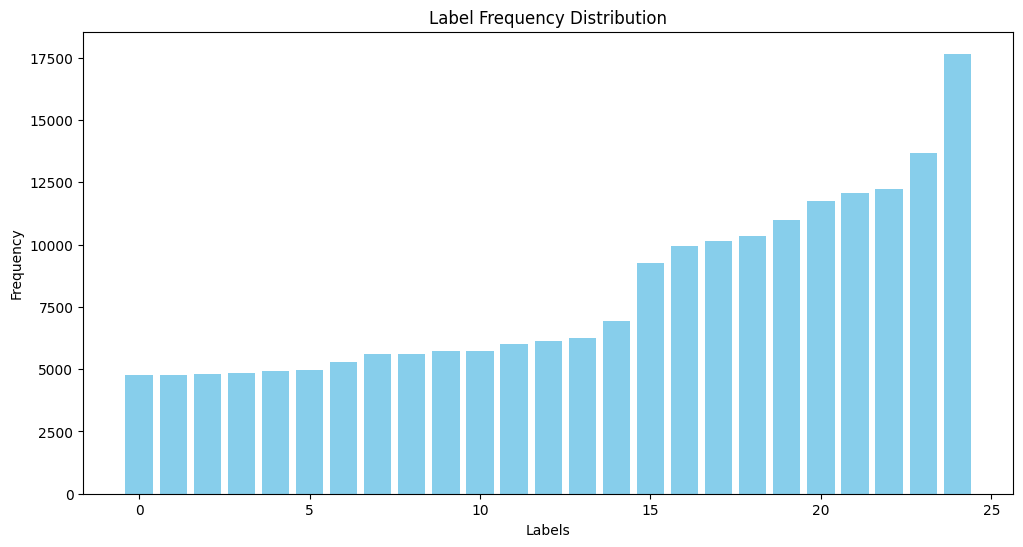

In [5]:
def plot_metrics(loss_history, metrics_history):
    epochs = len(loss_history)
    fig, ax1 = plt.subplots()

    # Plot loss on left y-axis with a distinct color (red)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(epochs), loss_history, color='tab:red', label='Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for metrics
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    
    # Define distinct colors for each metric
    metric_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink']
    
    # Plot each metric with its own color
    for i, (metric, values) in enumerate(metrics_history.items()):
        ax2.plot(range(epochs), values, label=metric, color=metric_colors[i % len(metric_colors)], linewidth=2)

    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Show legends for both loss and metrics
    fig.tight_layout()
    ax2.legend(loc='upper left')
    ax1.legend(loc='upper right')
    plt.title('Loss and Metrics Over Epochs')
    plt.show()
    
    

def compute_metrics(y_true, y_pred, y_prob):
    from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score
    metrics = {}
    
    # Micro precision
    metrics['micro_precision'] = precision_score(y_true, y_pred, average='micro', zero_division=0)
    
    # Macro precision
    metrics['macro_precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    
    # F1 Score
    metrics['f1_score'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Precision at k=4
    top_k = torch.topk(y_prob, k=4, dim=1).indices
    y_pred_at_k = torch.zeros_like(y_pred)
    for i, row in enumerate(top_k):
        y_pred_at_k[i, row] = 1
    metrics['precision_at_k'] = precision_score(y_true, y_pred_at_k, average='micro', zero_division=0)
    
    # AUC
    metrics['auc'] = roc_auc_score(y_true, y_prob, average='macro')
    
    # Accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    
    return metrics



# # Define the model
# class MultilabelANN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MultilabelANN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 512)  # First hidden layer
#         self.fc2 = nn.Linear(512, 256)        # Second hidden layer
#         self.fc3 = nn.Linear(256, output_dim) # Output layer
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))  # Apply ReLU on the first hidden layer
#         x = self.relu(self.fc2(x))  # Apply ReLU on the second hidden layer
#         x = self.sigmoid(self.fc3(x))  # Apply Sigmoid on the output layer
#         return x
    

# 2. Adjust the model by adding extra layers and dropout
class MultilabelANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultilabelANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc4 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
    

# Function to plot label frequencies
def plot_label_frequencies(Y):
    # Sum the occurrences of each label across all samples (column-wise sum)
    label_frequencies = np.sum(Y, axis=0)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(label_frequencies)), label_frequencies, color='skyblue')
    plt.title('Label Frequency Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.show()

# Assuming Y is your label matrix
# Call the function to plot label frequencies
plot_label_frequencies(Y)


Using device: cpu
Epoch [1/50], Loss: 0.3793, Micro Precision: 0.6807, Macro Precision: 0.4788, F1 Score: 0.2994, Precision at k=4: 0.4988, AUC: 0.7731, Accuracy: 0.0927
Epoch [2/50], Loss: 0.3618, Micro Precision: 0.6865, Macro Precision: 0.5624, F1 Score: 0.3105, Precision at k=4: 0.5024, AUC: 0.7779, Accuracy: 0.0937
Epoch [3/50], Loss: 0.3589, Micro Precision: 0.6731, Macro Precision: 0.6365, F1 Score: 0.3378, Precision at k=4: 0.5047, AUC: 0.7794, Accuracy: 0.0918
Epoch [4/50], Loss: 0.3572, Micro Precision: 0.6829, Macro Precision: 0.6599, F1 Score: 0.3275, Precision at k=4: 0.5046, AUC: 0.7811, Accuracy: 0.0942
Epoch [5/50], Loss: 0.3558, Micro Precision: 0.6705, Macro Precision: 0.6000, F1 Score: 0.3464, Precision at k=4: 0.5067, AUC: 0.7813, Accuracy: 0.0929
Epoch [6/50], Loss: 0.3550, Micro Precision: 0.6574, Macro Precision: 0.6461, F1 Score: 0.3541, Precision at k=4: 0.5050, AUC: 0.7820, Accuracy: 0.0960
Epoch [7/50], Loss: 0.3539, Micro Precision: 0.6775, Macro Precision: 

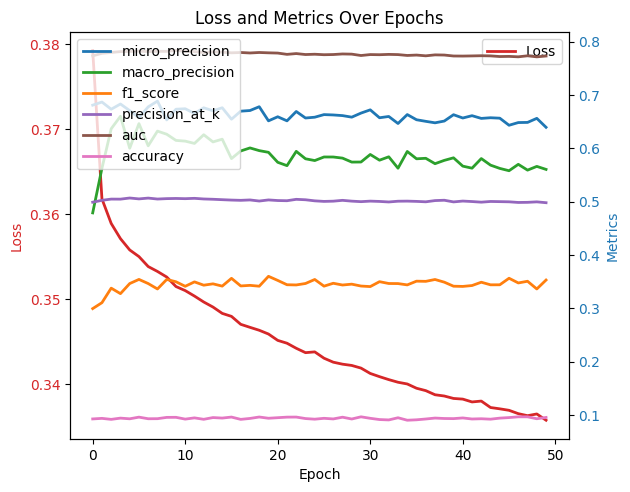

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn

# Step 0: Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

# Step 3: Model initialization and move to GPU
input_dim = X_train.shape[1]  # 661 features
output_dim = Y_train.shape[1]  # 203 labels
model = MultilabelANN(input_dim, output_dim).to(device)

# Step 4: Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel classification

optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Step 5: Training loop parameters
num_epochs = 50
batch_size = 64

# Step 6: Create DataLoader for batching the training data
train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Step 7: Training loop with metric calculation and plotting
loss_history = []
metrics_history = {
    'micro_precision': [],
    'macro_precision': [],
    'f1_score': [],
    'precision_at_k': [],
    'auc': [],
    'accuracy': []
}

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for this batch
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    # Evaluation and metrics computation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        Y_test_tensor = Y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        
        # Convert outputs to binary predictions (multilabel)
        predicted = (outputs > 0.5).float()

        # Compute metrics
        metrics = compute_metrics(Y_test, predicted, outputs)
        
        # Store metrics for plotting
        for key in metrics_history:
            metrics_history[key].append(metrics[key])
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, "
          f"Micro Precision: {metrics['micro_precision']:.4f}, "
          f"Macro Precision: {metrics['macro_precision']:.4f}, "
          f"F1 Score: {metrics['f1_score']:.4f}, "
          f"Precision at k=4: {metrics['precision_at_k']:.4f}, "
          f"AUC: {metrics['auc']:.4f}, "
          f"Accuracy: {metrics['accuracy']:.4f}")

# Step 8: Plot the loss and metrics
plot_metrics(loss_history, metrics_history)


In [9]:
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn

# Step 0: Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Split the data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Step 2: Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

# Step 3: Model initialization and move to GPU
input_dim = X_train.shape[1]  # 661 features
output_dim = Y_train.shape[1]  # 203 labels
model = MultilabelANN(input_dim, output_dim).to(device)

# Step 4: Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel classification
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Step 5: Training loop parameters
num_epochs = 50
batch_size = 64

# Step 6: Create DataLoader for batching the training and validation data
train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
val_data = torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

# Step 7: Training loop with metric calculation and validation evaluation
loss_history = []
val_loss_history = []
metrics_history = {
    'micro_precision': [],
    'macro_precision': [],
    'f1_score': [],
    'precision_at_k': [],
    'auc': [],
    'accuracy': []
}

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for this batch
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        val_outputs_list, val_labels_list = [], []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_outputs_list.append(outputs)
            val_labels_list.append(labels)

    avg_val_loss = val_running_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # Concatenate outputs and labels for metrics calculation
    val_outputs = torch.cat(val_outputs_list).cpu()
    val_labels = torch.cat(val_labels_list).cpu()

    # Convert outputs to binary predictions (multilabel)
    val_predicted = (val_outputs > 0.5).float()

    # Compute metrics
    metrics = compute_metrics(val_labels, val_predicted, val_outputs)
    
    # Store metrics for plotting
    for key in metrics_history:
        metrics_history[key].append(metrics[key])
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Micro Precision: {metrics['micro_precision']:.4f}, "
          f"Macro Precision: {metrics['macro_precision']:.4f}, "
          f"F1 Score: {metrics['f1_score']:.4f}, "
          f"Precision at k=4: {metrics['precision_at_k']:.4f}, "
          f"AUC: {metrics['auc']:.4f}, "
          f"Accuracy: {metrics['accuracy']:.4f}")

# Step 8: Final evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_predicted = (outputs > 0.5).float()
    test_metrics = compute_metrics(Y_test_tensor, test_predicted, outputs)
    print(f"Test Metrics: {test_metrics}")

# Step 9: Plot the loss and metrics
plot_metrics(loss_history, val_loss_history, metrics_history)


Using device: cpu
Epoch [1/50], Train Loss: 0.3828, Val Loss: 0.3636, Micro Precision: 0.6789, Macro Precision: 0.4708, F1 Score: 0.3064, Precision at k=4: 0.4962, AUC: 0.7762, Accuracy: 0.0930
Epoch [2/50], Train Loss: 0.3631, Val Loss: 0.3594, Micro Precision: 0.6814, Macro Precision: 0.5074, F1 Score: 0.3225, Precision at k=4: 0.5068, AUC: 0.7805, Accuracy: 0.0947
Epoch [3/50], Train Loss: 0.3600, Val Loss: 0.3582, Micro Precision: 0.6897, Macro Precision: 0.5381, F1 Score: 0.3212, Precision at k=4: 0.5089, AUC: 0.7809, Accuracy: 0.0997
Epoch [4/50], Train Loss: 0.3582, Val Loss: 0.3590, Micro Precision: 0.6895, Macro Precision: 0.6322, F1 Score: 0.3193, Precision at k=4: 0.5057, AUC: 0.7812, Accuracy: 0.0941
Epoch [5/50], Train Loss: 0.3570, Val Loss: 0.3571, Micro Precision: 0.6660, Macro Precision: 0.5822, F1 Score: 0.3557, Precision at k=4: 0.5067, AUC: 0.7852, Accuracy: 0.0946
Epoch [6/50], Train Loss: 0.3555, Val Loss: 0.3591, Micro Precision: 0.6997, Macro Precision: 0.6393, 

KeyboardInterrupt: 

In [7]:
# from sklearn.model_selection import train_test_split
# import torch
# import torch.optim as optim
# import torch.nn as nn

# # Step 1: Split the data into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Step 2: Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
# Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# # Step 3: Model initialization
# input_dim = X_train.shape[1]  # 661 features
# output_dim = Y_train.shape[1]  # 203 labels
# model = MultilabelANN(input_dim, output_dim)

# # Step 4: Define loss and optimizer
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel classification

# optimizer = optim.Adam(model.parameters(), lr=0.005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# # Step 5: Training loop parameters
# num_epochs = 20
# batch_size = 64

# # Step 6: Create DataLoader for batching the training data
# train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# # Step 7: Training loop with metric calculation and plotting
# loss_history = []
# metrics_history = {
#     'micro_precision': [],
#     'macro_precision': [],
#     'f1_score': [],
#     'precision_at_k': [],
#     'auc': [],
#     'accuracy': []
# }

# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         # Accumulate loss for this batch
#         running_loss += loss.item()
    
#     avg_loss = running_loss / len(train_loader)
#     loss_history.append(avg_loss)
    
#     # Evaluation and metrics computation
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         outputs = model(X_test_tensor)
        
#         # Convert outputs to binary predictions (multilabel)
#         predicted = (outputs > 0.5).float()
        
#         # Compute metrics
#         metrics = compute_metrics(Y_test, predicted, outputs)
        
#         # Store metrics for plotting
#         for key in metrics_history:
#             metrics_history[key].append(metrics[key])
    
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, "
#           f"Micro Precision: {metrics['micro_precision']:.4f}, "
#           f"Macro Precision: {metrics['macro_precision']:.4f}, "
#           f"F1 Score: {metrics['f1_score']:.4f}, "
#           f"Precision at k=4: {metrics['precision_at_k']:.4f}, "
#           f"AUC: {metrics['auc']:.4f}, "
#           f"Accuracy: {metrics['accuracy']:.4f}")

# # Step 8: Plot the loss and metrics
# plot_metrics(loss_history, metrics_history)

In [8]:

# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import train_test_split
# import numpy as np
# import torch

# # Function to apply RandomOverSampler to the entire dataset, resampling all labels simultaneously
# def apply_random_oversampling(X, Y):
#     ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    
#     # Flatten the Y matrix into a 1D array of tuples to retain the multilabel structure during resampling
#     Y_flattened = [''.join(map(str, y)) for y in Y]  # Convert each row into a string (e.g., '001')
    
#     # Resample the dataset based on the flattened labels
#     X_resampled, Y_resampled_flattened = ros.fit_resample(X, Y_flattened)
    
#     # Convert the flattened labels back to their original multilabel format
#     Y_resampled = np.array([list(map(int, y)) for y in Y_resampled_flattened])
    
#     return X_resampled, Y_resampled

# # Step 1: Split the data into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Step 2: Apply RandomOverSampler to the entire training dataset
# X_train_resampled, Y_train_resampled = apply_random_oversampling(X_train, Y_train)

# # Step 3: Convert the resampled data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train_resampled, dtype=torch.float32)
# Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# # Continue with model training as before
# input_dim = X_train.shape[1]  # 661 features
# output_dim = Y_train.shape[1]  # 203 labels
# model = MultilabelANN(input_dim, output_dim)

# # Define loss and optimizer
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel classification
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training loop parameters
# num_epochs = 20
# batch_size = 64

# # Create DataLoader for batching the resampled training data
# train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
# train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# # Training loop (rest of the code remains the same)
# loss_history = []
# metrics_history = {
#     'micro_precision': [],
#     'macro_precision': [],
#     'f1_score': [],
#     'precision_at_k': [],
#     'auc': [],
#     'accuracy': []
# }

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     loss_history.append(avg_loss)
    
#     # Evaluation
#     model.eval()
#     with torch.no_grad():
#         outputs = model(X_test_tensor)
#         predicted = (outputs > 0.5).float()
        
#         metrics = compute_metrics(Y_test, predicted, outputs)
#         for key in metrics_history:
#             metrics_history[key].append(metrics[key])

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, "
#           f"Micro Precision: {metrics['micro_precision']:.4f}, "
#           f"Macro Precision: {metrics['macro_precision']:.4f}, "
#           f"F1 Score: {metrics['f1_score']:.4f}, "
#           f"Precision at k=4: {metrics['precision_at_k']:.4f}, "
#           f"AUC: {metrics['auc']:.4f}, "
#           f"Accuracy: {metrics['accuracy']:.4f}")

# # After training, plot loss and metrics as usual
# plot_metrics(loss_history, metrics_history)
